In [1]:
# imports
import time
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import geopandas as gp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [200, 150]
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

first_datetime = datetime.datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
last_datetime = datetime.datetime.strptime('2018-02-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-07-01 00:00:00'
train_valid_split_datetime = datetime.datetime.strptime('2018-01-29 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-06-01 00:00:00'
print('first_datetime:', first_datetime)
print('last_datetime:', last_datetime)
print('train_valid_split_datetime:', train_valid_split_datetime)

first_datetime: 2018-01-01 00:00:00
last_datetime: 2018-02-01 00:00:00
train_valid_split_datetime: 2018-01-29 00:00:00


In [2]:
taxi_zone_lookup = pd.read_csv('nyc-tlc/misc/taxi _zone_lookup.csv')
print('taxi_zone_lookup:', taxi_zone_lookup.shape)
manhattan_location_ids = taxi_zone_lookup[taxi_zone_lookup['Borough']=='Manhattan']['LocationID'].values
manhattan_location_num = len(manhattan_location_ids)
print('manhattan_location_ids:', manhattan_location_ids.shape, manhattan_location_ids)
print('manhattan_location_num:', manhattan_location_num)

taxi_zone_lookup: (265, 4)
manhattan_location_ids: (69,) [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]
manhattan_location_num: 69


In [3]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [4]:
def get_5min_id(x):
    return (x-first_datetime).total_seconds()//(5*60)

def get_15min_id(x):
    return (x-first_datetime).total_seconds()//(15*60)

def get_30min_id(x):
    return (x-first_datetime).total_seconds()//(30*60)

In [5]:
first_5min_id = get_5min_id(first_datetime)
first_15min_id = get_15min_id(first_datetime)
first_30min_id = get_30min_id(first_datetime)
print('first_5min_id:', first_5min_id)
print('first_15min_id:', first_15min_id)
print('first_30min_id:', first_30min_id)
last_5min_id = get_5min_id(last_datetime)
last_15min_id = get_15min_id(last_datetime)
last_30min_id = get_30min_id(last_datetime)
print('last_5min_id:', last_5min_id)
print('last_15min_id:', last_15min_id)
print('last_30min_id:', last_30min_id)
train_valid_split_5min_id = get_5min_id(train_valid_split_datetime)
train_valid_split_15min_id = get_15min_id(train_valid_split_datetime)
train_valid_split_30min_id = get_30min_id(train_valid_split_datetime)
print('train_valid_split_5min_id:', train_valid_split_5min_id)
print('train_valid_split_15min_id:', train_valid_split_15min_id)
print('train_valid_split_30min_id:', train_valid_split_30min_id)

first_5min_id: 0.0
first_15min_id: 0.0
first_30min_id: 0.0
last_5min_id: 8928.0
last_15min_id: 2976.0
last_30min_id: 1488.0
train_valid_split_5min_id: 8064.0
train_valid_split_15min_id: 2688.0
train_valid_split_30min_id: 1344.0


In [6]:
def filter_abnormal_data(sample):
    start = time.time()
    sample_manhattan = sample[sample['PULocationID'].isin(manhattan_location_ids)].copy()
    print('filter PULocationID:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['tpep_pickup_datetime'] = pd.to_datetime(sample_manhattan['tpep_pickup_datetime'])
    print('tpep_pickup_datetime:', time.time()-start)
    sample_manhattan['tpep_dropoff_datetime'] = pd.to_datetime(sample_manhattan['tpep_dropoff_datetime'])
    print('tpep_dropoff_datetime:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] > 0]
    print('filter trip_distance:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_duration'] = (sample_manhattan['tpep_dropoff_datetime']-sample_manhattan['tpep_pickup_datetime']).dt.total_seconds()
    print('trip_duration:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] > 0]
    print('filter trip_duration:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_speed'] = sample_manhattan['trip_distance']/sample_manhattan['trip_duration']*3600
    print('trip_speed:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] > 0]
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] <= 200]
    print('filter trip_speed:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] > 0]
    print('filter total_amount:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] >= first_datetime]
    print('filter tpep_pickup_datetime first_datetime:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] < last_datetime]
    print('filter tpep_pickup_datetime last_datetime:', sample_manhattan.shape, time.time()-start)
    return sample_manhattan

In [7]:
demo = False
if demo:
    sample = pd.read_csv('nyc-tlc/trip data/sample.csv')
    sample_manhattan = filter_abnormal_data(sample)
else:
    for m in range(1, 2):  # (1, 7)
        start = time.time()
        sample_1 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-0' + str(m) + '.csv')
        print('read_csv 2018-0'+str(m)+':', time.time()-start)
        sample_1 = filter_abnormal_data(sample_1)
        print('filter_abnormal_data:', time.time()-start)
        if m == 1:
            sample_manhattan = sample_1
        else:
            sample_manhattan = pd.concat([sample_manhattan, sample_1], axis=0)
        print('concat:', time.time()-start)
print('sample_manhattan:', sample_manhattan.shape)

start = time.time()

m = np.mean(sample_manhattan['total_amount'])
s = np.std(sample_manhattan['total_amount'])
print('total_amount m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] <= m + 10*s]
#sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] >= m - 10*s]
print('filter total_amount:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_distance'])
s = np.std(sample_manhattan['trip_distance'])
print('trip_distance m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] <= m + 20*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] >= m - 20*s]
print('filter trip_distance:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
print('trip_duration m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', sample_manhattan.shape, time.time()-start)

print('sample_manhattan.shape:', sample_manhattan.shape)

read_csv 2018-01: 25.8574378490448
filter PULocationID: (7965703, 17) 6.87434196472168
tpep_pickup_datetime: 8.647110939025879
tpep_dropoff_datetime: 10.206984996795654
filter trip_distance: (7935134, 17) 11.616662979125977
trip_duration: 11.91078495979309
filter trip_duration: (7935017, 18) 13.74158787727356
trip_speed: 13.82912302017212
filter trip_speed: (7931840, 19) 16.987854957580566
filter total_amount: (7928802, 19) 17.92640495300293
filter tpep_pickup_datetime first_datetime: (7928569, 19) 18.870553731918335
filter tpep_pickup_datetime last_datetime: (7928497, 19) 19.861657857894897
filter_abnormal_data: 46.028728008270264
concat: 46.02937197685242
sample_manhattan: (7928497, 19)
total_amount m: 13.526606089401307 s: 9.692531310002575
filter total_amount: (7925658, 19) 0.9312589168548584
trip_distance m: 2.233562362897817 s: 2.4878265305725793
filter trip_distance: (7925654, 19) 1.9349908828735352
trip_duration m: 870.7019522931483 s: 3550.1005807871866
filter trip_duration: (

In [8]:
start = time.time()
#sample_manhattan['tpep_pickup_date'] = sample_manhattan['tpep_pickup_datetime'].dt.date
#print('tpep_pickup_date:', time.time()-start)
#sample_manhattan['tpep_dropoff_date'] = sample_manhattan['tpep_dropoff_datetime'].dt.date
#print('tpep_dropoff_date:', time.time()-start)
sample_manhattan['tpep_pickup_year'] = sample_manhattan['tpep_pickup_datetime'].dt.year
print('tpep_pickup_year:', time.time()-start)
sample_manhattan['tpep_pickup_month'] = sample_manhattan['tpep_pickup_datetime'].dt.month
print('tpep_pickup_month:', time.time()-start)
sample_manhattan['tpep_pickup_day'] = sample_manhattan['tpep_pickup_datetime'].dt.day
print('tpep_pickup_day:', time.time()-start)
sample_manhattan['tpep_pickup_hour'] = sample_manhattan['tpep_pickup_datetime'].dt.hour
print('tpep_pickup_hour:', time.time()-start)
sample_manhattan['tpep_pickup_weekday'] = sample_manhattan['tpep_pickup_datetime'].dt.weekday
print('tpep_pickup_weekday:', time.time()-start)
sample_manhattan['is_weekend'] = sample_manhattan['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
print('is_weekend:', time.time()-start)
sample_manhattan['is_morning_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
print('is_morning_peak:', time.time()-start)
sample_manhattan['is_evening_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
print('is_evening_peak:', time.time()-start)
sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x == 'N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)

#store_and_fwd_flag_dummy = pd.get_dummies(sample_manhattan['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
#print('store_and_fwd_flag_dummy:', time.time()-start)
#passenger_count_dummy = pd.get_dummies(sample_manhattan['passenger_count'], prefix='pc', prefix_sep='_')
#print('passenger_count_dummy:', time.time()-start)
#RatecodeID_dummy = pd.get_dummies(sample_manhattan['RatecodeID'], prefix='rc', prefix_sep='_')
#print('RatecodeID_dummy:', time.time()-start)
#payment_type_dummy = pd.get_dummies(sample_manhattan['payment_type'], prefix='pt', prefix_sep='_')
#print('payment_type_dummy:', time.time()-start)

#sample_manhattan = pd.concat([sample_manhattan, store_and_fwd_flag_dummy, passenger_count_dummy, RatecodeID_dummy, payment_type_dummy], axis=1)  # TODO memory error
#print('concat:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(5*60)
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(15*60)
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(30*60)
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)  # , 'tpep_pickup_date', 'tpep_dropoff_date'

tpep_pickup_year: 0.30678892135620117
tpep_pickup_month: 0.5478808879852295
tpep_pickup_day: 0.8316800594329834
tpep_pickup_hour: 1.105752944946289
tpep_pickup_weekday: 1.4176158905029297
is_weekend: 4.147779941558838
is_morning_peak: 6.938730001449585
is_evening_peak: 10.17284083366394
store_and_fwd_flag: 13.005795001983643
tpep_pickup_5min_id: 13.53933310508728
tpep_pickup_15min_id: 14.051471948623657
tpep_pickup_30min_id: 14.528438091278076


In [9]:
sample_manhattan.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,1,0.500,1,1,41,24,2,4.500,0.500,0.500,0.000,0.000,0.300,5.800,198.000,9.091,2018,1,1,0,0,0,0,0,4.000,1.000,0.000
1,1,1,2.700,1,1,239,140,2,14.000,0.500,0.500,0.000,0.000,0.300,15.300,1090.000,8.917,2018,1,1,0,0,0,0,0,8.000,2.000,1.000
2,1,2,0.800,1,1,262,141,1,6.000,0.500,0.500,1.000,0.000,0.300,8.300,355.000,8.113,2018,1,1,0,0,0,0,0,1.000,0.000,0.000
3,1,1,10.200,1,1,140,257,2,33.500,0.500,0.500,0.000,0.000,0.300,34.800,1949.000,18.840,2018,1,1,0,0,0,0,0,4.000,1.000,0.000
4,1,2,2.500,1,1,246,239,1,12.500,0.500,0.500,2.750,0.000,0.300,16.550,1068.000,8.427,2018,1,1,0,0,0,0,0,1.000,0.000,0.000


In [10]:
sample_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
count,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000
mean,1.563,1.610,2.232,1.013,1.000,165.066,162.319,1.305,10.646,0.319,0.499,1.579,0.131,0.300,13.477,722.656,10.756,2018.000,1.000,16.733,13.725,2.853,0.257,0.136,0.188,4701.323,1566.774,783.137
std,0.496,1.261,2.484,0.171,0.000,66.235,69.048,0.474,7.540,0.402,0.023,1.832,0.994,0.003,9.316,511.095,5.269,0.000,0.000,8.708,6.041,1.957,0.437,0.342,0.391,2510.091,836.697,418.349
min,1.000,0.000,0.010,1.000,1.000,4.000,1.000,1.000,0.000,-0.500,0.000,0.000,0.000,0.000,0.300,1.000,0.005,2018.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.900,1.000,1.000,114.000,113.000,1.000,6.000,0.000,0.500,0.000,0.000,0.300,8.160,368.000,7.385,2018.000,1.000,10.000,9.000,1.000,0.000,0.000,0.000,2683.000,894.000,447.000
50%,2.000,1.000,1.490,1.000,1.000,162.000,162.000,1.000,8.500,0.000,0.500,1.360,0.000,0.300,11.000,597.000,9.704,2018.000,1.000,17.000,14.000,3.000,0.000,0.000,0.000,4789.000,1596.000,798.000
75%,2.000,2.000,2.500,1.000,1.000,234.000,234.000,2.000,12.500,0.500,0.500,2.200,0.000,0.300,15.360,938.000,12.813,2018.000,1.000,24.000,19.000,5.000,1.000,0.000,0.000,6878.000,2292.000,1146.000
max,2.000,9.000,51.900,99.000,1.000,263.000,265.000,4.000,110.000,60.000,0.500,100.510,95.750,0.300,110.400,7966.000,200.000,2018.000,1.000,31.000,23.000,6.000,1.000,1.000,1.000,8927.000,2975.000,1487.000


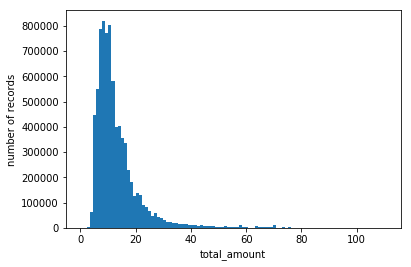

In [11]:
plt.hist(sample_manhattan['total_amount'].values, bins=100)
plt.xlabel('total_amount')
plt.ylabel('number of records')
plt.show()

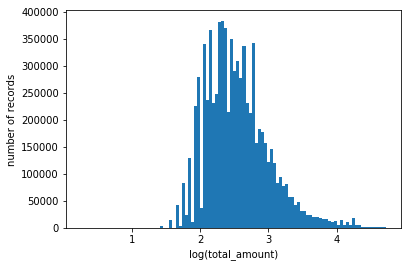

In [12]:
sample_manhattan['log_total_amount'] = np.log(sample_manhattan['total_amount'].values + 1)
plt.hist(sample_manhattan['log_total_amount'].values, bins=100)
plt.xlabel('log(total_amount)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

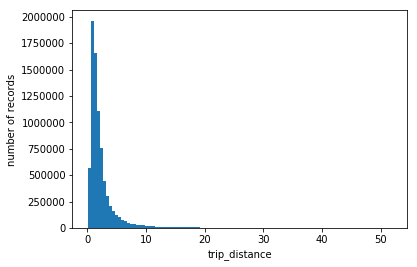

In [13]:
plt.hist(sample_manhattan['trip_distance'].values, bins=100)
plt.xlabel('trip_distance')
plt.ylabel('number of records')
plt.show()

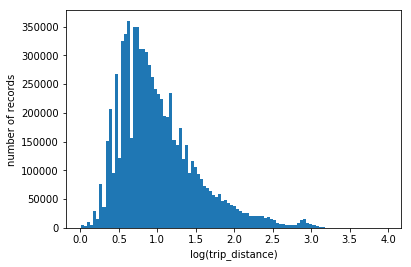

In [14]:
sample_manhattan['log_trip_distance'] = np.log(sample_manhattan['trip_distance'].values + 1)
plt.hist(sample_manhattan['log_trip_distance'].values, bins=100)
plt.xlabel('log(trip_distance)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

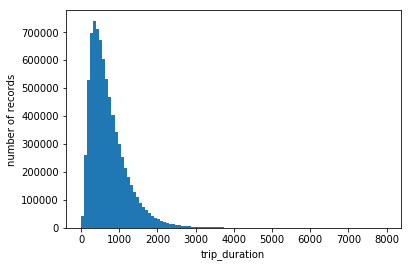

In [15]:
plt.hist(sample_manhattan['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

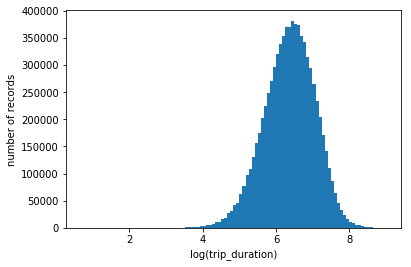

In [16]:
sample_manhattan['log_trip_duration'] = np.log(sample_manhattan['trip_duration'].values + 1)
plt.hist(sample_manhattan['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

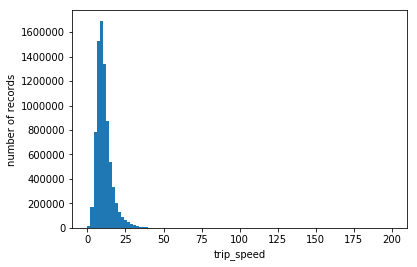

In [17]:
plt.hist(sample_manhattan['trip_speed'].values, bins=100)
plt.xlabel('trip_speed')
plt.ylabel('number of records')
plt.show()

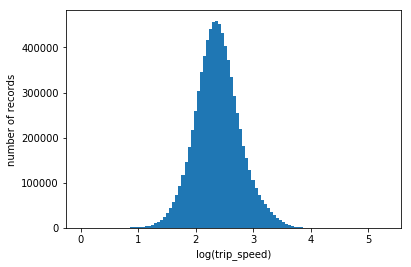

In [18]:
sample_manhattan['log_trip_speed'] = np.log(sample_manhattan['trip_speed'].values + 1)
plt.hist(sample_manhattan['log_trip_speed'].values, bins=100)
plt.xlabel('log(trip_speed)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

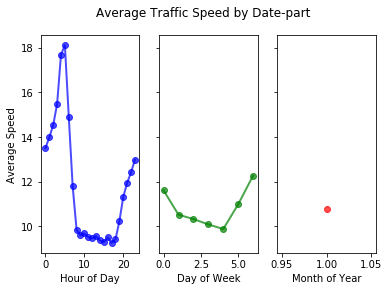

In [19]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(sample_manhattan.groupby('tpep_pickup_hour').mean()['trip_speed'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(sample_manhattan.groupby('tpep_pickup_weekday').mean()['trip_speed'], 'go-', lw=2, alpha=0.7)
ax[2].plot(sample_manhattan.groupby('tpep_pickup_month').mean()['trip_speed'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

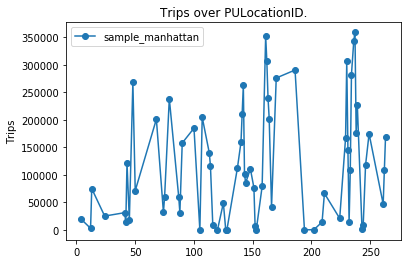

In [20]:
plt.plot(sample_manhattan.groupby(['PULocationID']).count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over PULocationID.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

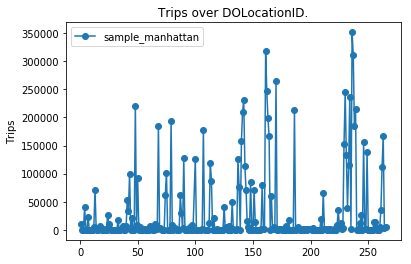

In [21]:
plt.plot(sample_manhattan.groupby(['DOLocationID']).count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over DOLocationID.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

In [22]:
taxi_zones_shape = gp.GeoDataFrame.from_file('nyc-tlc/misc/taxi_zones/taxi_zones.shp')
taxi_zones_shape = taxi_zones_shape[taxi_zones_shape['borough'] == 'Manhattan']
taxi_zones_shape.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ..."
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,..."
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,..."
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,..."


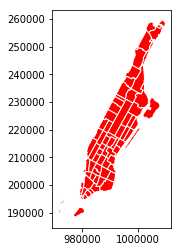

In [24]:
taxi_zones_shape.plot(color='red', edgecolor='white')

In [25]:
PULocationID_group = sample_manhattan.groupby(['PULocationID']).count()[['VendorID']]
PULocationID_group['VendorID'] = PULocationID_group['VendorID']/sample_manhattan.shape[0]*100
PULocationID_group.head()

,VendorID
PULocationID,
4,0.246
12,0.037
13,0.949
24,0.318
41,0.396


In [27]:
taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
taxi_zones_shape_requests.fillna(0, inplace=True)
print('taxi_zones_shape_requests:', taxi_zones_shape_requests.shape)

taxi_zones_shape_requests: (69, 8)


In [28]:
taxi_zones_shape_requests.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,VendorID
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",0.246
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ...",0.037
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,...",0.949
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,...",0.318
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,...",0.396


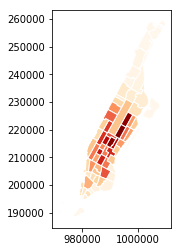

In [29]:
taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')

In [27]:
#for group_name, group_data in sample_manhattan.groupby(['tpep_pickup_5min_id']):
#    #print('group_name:', group_name)
#    #print(group_data.head())
#    PULocationID_group = group_data.groupby(['PULocationID']).count()[['VendorID']]
#    PULocationID_group['VendorID'] = PULocationID_group['VendorID']/sample_manhattan.shape[0]*100
#    #PULocationID_group.head()
#    taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
#    taxi_zones_shape_requests.fillna(0, inplace=True)
#    #taxi_zones_shape_requests.head()
#    #print('taxi_zones_shape_requests:', type(taxi_zones_shape_requests))
#    fig = taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')
#    fig.get_figure().savefig('images/'+str(group_name)+'.png')

In [57]:
all_5min_id = np.array([i for i in range(int(last_5min_id)) for _ in range(manhattan_location_num)])
all_5min_LocationID = np.array([i for _ in range(int(last_5min_id)) for i in manhattan_location_ids])
print('all_5min_id:', all_5min_id.shape, all_5min_id)
print('all_5min_LocationID:', all_5min_LocationID.shape, all_5min_LocationID)
all_5min_index = pd.DataFrame({'tpep_pickup_5min_id': all_5min_id, 'LocationID': all_5min_LocationID})
all_5min_index.set_index(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('all_5min_index:', all_5min_index.shape)

all_5min_id: (616032,) [   0    0    0 ... 8927 8927 8927]
all_5min_LocationID: (616032,) [  4  12  13 ... 261 262 263]
all_5min_index: (616032, 0)


In [58]:
all_5min_index.head()

Empty DataFrame
Columns: []
Index: [(0, 4), (0, 12), (0, 13), (0, 24), (0, 41)]

In [59]:
sample_5min_group = sample_manhattan.groupby(['tpep_pickup_5min_id', 'PULocationID'])
sample_5min_count = sample_5min_group.count()
sample_5min_count.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_count:', sample_5min_count.shape)
sample_5min_mean = sample_5min_group.mean()
sample_5min_mean.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_mean:', sample_5min_mean.shape)
sample_5min_sum = sample_5min_group.sum()
sample_5min_sum.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_sum:', sample_5min_sum.shape)
sample_5min_dropoff_group = sample_manhattan.groupby(['tpep_pickup_5min_id', 'DOLocationID'])
sample_5min_dropoff_count = sample_5min_dropoff_group.count()
sample_5min_dropoff_count.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_dropoff_count:', sample_5min_dropoff_count.shape)
sample_5min_dropoff_mean = sample_5min_dropoff_group.mean()
sample_5min_dropoff_mean.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_dropoff_mean:', sample_5min_dropoff_mean.shape)
sample_5min_dropoff_sum = sample_5min_dropoff_group.sum()
sample_5min_dropoff_sum.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_dropoff_sum:', sample_5min_dropoff_sum.shape)

sample_5min_count: (475844, 30)
sample_5min_mean: (475844, 30)
sample_5min_sum: (475844, 30)
sample_5min_dropoff_count: (738210, 30)
sample_5min_dropoff_mean: (738210, 30)
sample_5min_dropoff_sum: (738210, 30)


In [60]:
sample_5min_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  3                3              3   
                    13                 4                4              4   
                    24                 2                2              2   
                    41                 3                3              3   
                    42                 3                3              3   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    3                   3             3   
                    13                   4                   4             4   
                    24                   2                   2             2   
                    41                   3                   3             3   
                    42                   3                   3             3   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      3            3      3        3   
                    13                     4            4      4        4   
                    24                     2            2      2        2   
                    41                     3            3      3        3   
                    42                     3            3      3        3   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                    3             3   
                    13                   4             4   
                    24                   2             2   
                    41                   3             3   
                    42                   3             3   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                               3             3   
                    13                              4             4   
                    24                              2             2   
                    41                              3             3   
                    42                              3             3   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                       3           3                 3   
                    13                      4           4                 4   
                    24                      2           2                 2   
                    41                      3           3                 3   
                    42                      3           3                 3   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                           3                3   
                    13                          4                4   
                    24                          2                2   
                    41                          3                3   
                    42                          3                3   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                          3                    3   
                    13                         4                    4   
                    24                         2                    2   
                    41                         3                    3

In [61]:
sample_5min_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4              1.333            1.667          1.203   
                    13             2.000            1.000          2.435   
                    24             2.000            1.500          2.775   
                    41             1.333            1.333          1.317   
                    42             1.667            1.667          4.920   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                1.000               1.000       189.667   
                    13               1.000               1.000       161.250   
                    24               1.000               1.000       142.500   
                    41               1.000               1.000       118.333   
                    42               1.000               1.000       140.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                  1.333        7.500  0.500    0.500   
                    13                 1.500       10.125  0.500    0.500   
                    24                 2.000       11.500  0.500    0.500   
                    41                 1.667        7.000  0.500    0.500   
                    42                 1.333       19.333  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                0.817         0.000   
                    13               0.580         0.000   
                    24               0.000         0.000   
                    41               0.567         0.000   
                    42               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.300         9.617   
                    13                          0.300        12.005   
                    24                          0.300        12.800   
                    41                          0.300         8.867   
                    42                          0.300        20.633   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                 501.000       9.918          2018.000   
                    13                524.500      15.570          2018.000   
                    24                709.500      13.941          2018.000   
                    41                376.333      12.232          2018.000   
                    42               1317.000      14.847          2018.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                       1.000            1.000   
                    13                      1.000            1.000   
                    24                      1.000            1.000   
                    41                      1.000            1.000   
                    42                      1.000            1.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                      0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000   
                    41                     0.000                0.000

In [62]:
sample_5min_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  4                5          3.610   
                    13                 8                4          9.740   
                    24                 4                3          5.550   
                    41                 4                4          3.950   
                    42                 5                5         14.760   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    3                   3           569   
                    13                   4                   4           645   
                    24                   2                   2           285   
                    41                   3                   3           355   
                    42                   3                   3           420   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      4       22.500  1.500    1.500   
                    13                     6       40.500  2.000    2.000   
                    24                     4       23.000  1.000    1.000   
                    41                     5       21.000  1.500    1.500   
                    42                     4       58.000  1.500    1.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                2.450         0.000   
                    13               2.320         0.000   
                    24               0.000         0.000   
                    41               1.700         0.000   
                    42               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.900        28.850   
                    13                          1.200        48.020   
                    24                          0.600        25.600   
                    41                          0.900        26.600   
                    42                          0.900        61.900   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                1503.000      29.755              6054   
                    13               2098.000      62.280              8072   
                    24               1419.000      27.883              4036   
                    41               1129.000      36.696              6054   
                    42               3951.000      44.540              6054   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                           3                3   
                    13                          4                4   
                    24                          2                2   
                    41                          3                3   
                    42                          3                3   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                          0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0

In [63]:
sample_5min_dropoff_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  4                4              4   
                    7                  2                2              2   
                    13                 3                3              3   
                    17                 1                1              1   
                    18                 1                1              1   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    4                   4             4   
                    7                    2                   2             2   
                    13                   3                   3             3   
                    17                   1                   1             1   
                    18                   1                   1             1   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      4            4      4        4   
                    7                      2            2      2        2   
                    13                     3            3      3        3   
                    17                     1            1      1        1   
                    18                     1            1      1        1   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                    4             4   
                    7                    2             2   
                    13                   3             3   
                    17                   1             1   
                    18                   1             1   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                               4             4   
                    7                               2             2   
                    13                              3             3   
                    17                              1             1   
                    18                              1             1   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                       4           4                 4   
                    7                       2           2                 2   
                    13                      3           3                 3   
                    17                      1           1                 1   
                    18                      1           1                 1   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                           4                4   
                    7                           2                2   
                    13                          3                3   
                    17                          1                1   
                    18                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                          4                    4   
                    7                          2                    2   
                    13                         3                    3   
                    17                         1                    1

In [64]:
sample_5min_dropoff_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4              1.750            2.250          1.765   
                    7              1.500            1.500          6.375   
                    13             1.667            1.000          0.990   
                    17             2.000            1.000          6.700   
                    18             1.000            2.000          9.800   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                1.000               1.000        97.000   
                    7                1.000               1.000       120.500   
                    13               1.000               1.000       119.333   
                    17               1.000               1.000        43.000   
                    18               1.000               1.000       162.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                  1.750        7.875  0.500    0.500   
                    7                  2.000       22.500  0.500    0.500   
                    13                 1.667        5.833  0.500    0.500   
                    17                 2.000       21.500  0.500    0.500   
                    18                 2.000       30.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                0.362         0.000   
                    7                0.000         0.000   
                    13               0.320         0.000   
                    17               0.000         0.000   
                    18               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.300         9.538   
                    7                           0.300        23.800   
                    13                          0.300         7.453   
                    17                          0.300        22.800   
                    18                          0.300        31.800   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                 427.750      14.872          2018.000   
                    7                1529.500      15.004          2018.000   
                    13                306.667      12.820          2018.000   
                    17               1174.000      20.545          2018.000   
                    18               1618.000      21.805          2018.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                       1.000            1.000   
                    7                       1.000            1.000   
                    13                      1.000            1.000   
                    17                      1.000            1.000   
                    18                      1.000            1.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                      0.000                0.000   
                    7                      0.000                0.000   
                    13                     0.000                0.000   
                    17                     0.000                0.000

In [65]:
sample_5min_dropoff_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  7                9          7.060   
                    7                  3                3         12.750   
                    13                 5                3          2.970   
                    17                 2                1          6.700   
                    18                 1                2          9.800   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    4                   4           388   
                    7                    2                   2           241   
                    13                   3                   3           358   
                    17                   1                   1            43   
                    18                   1                   1           162   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      7       31.500  2.000    2.000   
                    7                      4       45.000  1.000    1.000   
                    13                     5       17.500  1.500    1.500   
                    17                     2       21.500  0.500    0.500   
                    18                     2       30.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                1.450         0.000   
                    7                0.000         0.000   
                    13               0.960         0.000   
                    17               0.000         0.000   
                    18               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           1.200        38.150   
                    7                           0.600        47.600   
                    13                          0.900        22.360   
                    17                          0.300        22.800   
                    18                          0.300        31.800   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                1711.000      59.487              8072   
                    7                3059.000      30.007              4036   
                    13                920.000      38.460              6054   
                    17               1174.000      20.545              2018   
                    18               1618.000      21.805              2018   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                           4                4   
                    7                           2                2   
                    13                          3                3   
                    17                          1                1   
                    18                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                          0                    0   
                    7                          0                    0   
                    13                         0                    0   
                    17                         0                    0

In [73]:
all_5min_count = all_5min_index.join(sample_5min_count, how='left')
all_5min_count.fillna(0, inplace=True)
print('all_5min_count:', all_5min_count.shape)
all_5min_mean = all_5min_index.join(sample_5min_mean, how='left')
all_5min_mean.fillna(0, inplace=True)
print('all_5min_mean:', all_5min_mean.shape)
all_5min_sum = all_5min_index.join(sample_5min_sum, how='left')
all_5min_sum.fillna(0, inplace=True)
print('all_5min_sum:', all_5min_sum.shape)
all_5min_dropoff_count = all_5min_index.join(sample_5min_dropoff_count, how='left')
all_5min_dropoff_count.fillna(0, inplace=True)
print('all_5min_dropoff_count:', all_5min_dropoff_count.shape)
all_5min_dropoff_mean = all_5min_index.join(sample_5min_dropoff_mean, how='left')
all_5min_dropoff_mean.fillna(0, inplace=True)
print('all_5min_dropoff_mean:', all_5min_dropoff_mean.shape)
all_5min_dropoff_sum = all_5min_index.join(sample_5min_dropoff_sum, how='left')
all_5min_dropoff_sum.fillna(0, inplace=True)
print('all_5min_dropoff_sum:', all_5min_dropoff_sum.shape)

all_5min_count: (616032, 30)
all_5min_mean: (616032, 30)
all_5min_sum: (616032, 30)
all_5min_dropoff_count: (616032, 30)
all_5min_dropoff_mean: (616032, 30)
all_5min_dropoff_sum: (616032, 30)


In [74]:
all_5min_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              3.000            3.000          3.000   
                    12             0.000            0.000          0.000   
                    13             4.000            4.000          4.000   
                    24             2.000            2.000          2.000   
                    41             3.000            3.000          3.000   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                3.000               3.000         3.000   
                    12               0.000               0.000         0.000   
                    13               4.000               4.000         4.000   
                    24               2.000               2.000         2.000   
                    41               3.000               3.000         3.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  3.000        3.000  3.000    3.000   
                    12                 0.000        0.000  0.000    0.000   
                    13                 4.000        4.000  4.000    4.000   
                    24                 2.000        2.000  2.000    2.000   
                    41                 3.000        3.000  3.000    3.000   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                3.000         3.000   
                    12               0.000         0.000   
                    13               4.000         4.000   
                    24               2.000         2.000   
                    41               3.000         3.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           3.000         3.000   
                    12                          0.000         0.000   
                    13                          4.000         4.000   
                    24                          2.000         2.000   
                    41                          3.000         3.000   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                   3.000       3.000             3.000   
                    12                  0.000       0.000             0.000   
                    13                  4.000       4.000             4.000   
                    24                  2.000       2.000             2.000   
                    41                  3.000       3.000             3.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       3.000            3.000   
                    12                      0.000            0.000   
                    13                      4.000            4.000   
                    24                      2.000            2.000   
                    41                      3.000            3.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      3.000                3.000   
                    12                     0.000                0.000   
                    13                     4.000                4.000   
                    24                     2.000                2.000

In [75]:
all_5min_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              1.333            1.667          1.203   
                    12             0.000            0.000          0.000   
                    13             2.000            1.000          2.435   
                    24             2.000            1.500          2.775   
                    41             1.333            1.333          1.317   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                1.000               1.000       189.667   
                    12               0.000               0.000         0.000   
                    13               1.000               1.000       161.250   
                    24               1.000               1.000       142.500   
                    41               1.000               1.000       118.333   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  1.333        7.500  0.500    0.500   
                    12                 0.000        0.000  0.000    0.000   
                    13                 1.500       10.125  0.500    0.500   
                    24                 2.000       11.500  0.500    0.500   
                    41                 1.667        7.000  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                0.817         0.000   
                    12               0.000         0.000   
                    13               0.580         0.000   
                    24               0.000         0.000   
                    41               0.567         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           0.300         9.617   
                    12                          0.000         0.000   
                    13                          0.300        12.005   
                    24                          0.300        12.800   
                    41                          0.300         8.867   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                 501.000       9.918          2018.000   
                    12                  0.000       0.000             0.000   
                    13                524.500      15.570          2018.000   
                    24                709.500      13.941          2018.000   
                    41                376.333      12.232          2018.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       1.000            1.000   
                    12                      0.000            0.000   
                    13                      1.000            1.000   
                    24                      1.000            1.000   
                    41                      1.000            1.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      0.000                0.000   
                    12                     0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000

In [76]:
all_5min_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              4.000            5.000          3.610   
                    12             0.000            0.000          0.000   
                    13             8.000            4.000          9.740   
                    24             4.000            3.000          5.550   
                    41             4.000            4.000          3.950   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                3.000               3.000       569.000   
                    12               0.000               0.000         0.000   
                    13               4.000               4.000       645.000   
                    24               2.000               2.000       285.000   
                    41               3.000               3.000       355.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  4.000       22.500  1.500    1.500   
                    12                 0.000        0.000  0.000    0.000   
                    13                 6.000       40.500  2.000    2.000   
                    24                 4.000       23.000  1.000    1.000   
                    41                 5.000       21.000  1.500    1.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                2.450         0.000   
                    12               0.000         0.000   
                    13               2.320         0.000   
                    24               0.000         0.000   
                    41               1.700         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           0.900        28.850   
                    12                          0.000         0.000   
                    13                          1.200        48.020   
                    24                          0.600        25.600   
                    41                          0.900        26.600   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                1503.000      29.755          6054.000   
                    12                  0.000       0.000             0.000   
                    13               2098.000      62.280          8072.000   
                    24               1419.000      27.883          4036.000   
                    41               1129.000      36.696          6054.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       3.000            3.000   
                    12                      0.000            0.000   
                    13                      4.000            4.000   
                    24                      2.000            2.000   
                    41                      3.000            3.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      0.000                0.000   
                    12                     0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000

In [77]:
all_5min_dropoff_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              4.000            4.000          4.000   
                    12             0.000            0.000          0.000   
                    13             3.000            3.000          3.000   
                    24             2.000            2.000          2.000   
                    41             2.000            2.000          2.000   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                4.000               4.000         4.000   
                    12               0.000               0.000         0.000   
                    13               3.000               3.000         3.000   
                    24               2.000               2.000         2.000   
                    41               2.000               2.000         2.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  4.000        4.000  4.000    4.000   
                    12                 0.000        0.000  0.000    0.000   
                    13                 3.000        3.000  3.000    3.000   
                    24                 2.000        2.000  2.000    2.000   
                    41                 2.000        2.000  2.000    2.000   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                4.000         4.000   
                    12               0.000         0.000   
                    13               3.000         3.000   
                    24               2.000         2.000   
                    41               2.000         2.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           4.000         4.000   
                    12                          0.000         0.000   
                    13                          3.000         3.000   
                    24                          2.000         2.000   
                    41                          2.000         2.000   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                   4.000       4.000             4.000   
                    12                  0.000       0.000             0.000   
                    13                  3.000       3.000             3.000   
                    24                  2.000       2.000             2.000   
                    41                  2.000       2.000             2.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       4.000            4.000   
                    12                      0.000            0.000   
                    13                      3.000            3.000   
                    24                      2.000            2.000   
                    41                      2.000            2.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      4.000                4.000   
                    12                     0.000                0.000   
                    13                     3.000                3.000   
                    24                     2.000                2.000

In [78]:
all_5min_dropoff_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              1.750            2.250          1.765   
                    12             0.000            0.000          0.000   
                    13             1.667            1.000          0.990   
                    24             2.000            1.000          3.050   
                    41             1.500            1.000          1.320   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                1.000               1.000        97.000   
                    12               0.000               0.000         0.000   
                    13               1.000               1.000       119.333   
                    24               1.000               1.000       234.000   
                    41               1.000               1.000       140.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  1.750        7.875  0.500    0.500   
                    12                 0.000        0.000  0.000    0.000   
                    13                 1.667        5.833  0.500    0.500   
                    24                 2.000       11.750  0.500    0.500   
                    41                 1.500        7.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                0.362         0.000   
                    12               0.000         0.000   
                    13               0.320         0.000   
                    24               0.000         0.000   
                    41               0.850         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           0.300         9.538   
                    12                          0.000         0.000   
                    13                          0.300         7.453   
                    24                          0.300        13.050   
                    41                          0.300         9.650   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                 427.750      14.872          2018.000   
                    12                  0.000       0.000             0.000   
                    13                306.667      12.820          2018.000   
                    24                733.000      14.451          2018.000   
                    41                424.500      10.980          2018.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       1.000            1.000   
                    12                      0.000            0.000   
                    13                      1.000            1.000   
                    24                      1.000            1.000   
                    41                      1.000            1.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      0.000                0.000   
                    12                     0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000

In [79]:
all_5min_dropoff_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              7.000            9.000          7.060   
                    12             0.000            0.000          0.000   
                    13             5.000            3.000          2.970   
                    24             4.000            2.000          6.100   
                    41             3.000            2.000          2.640   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                4.000               4.000       388.000   
                    12               0.000               0.000         0.000   
                    13               3.000               3.000       358.000   
                    24               2.000               2.000       468.000   
                    41               2.000               2.000       280.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  7.000       31.500  2.000    2.000   
                    12                 0.000        0.000  0.000    0.000   
                    13                 5.000       17.500  1.500    1.500   
                    24                 4.000       23.500  1.000    1.000   
                    41                 3.000       15.000  1.000    1.000   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                1.450         0.000   
                    12               0.000         0.000   
                    13               0.960         0.000   
                    24               0.000         0.000   
                    41               1.700         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           1.200        38.150   
                    12                          0.000         0.000   
                    13                          0.900        22.360   
                    24                          0.600        26.100   
                    41                          0.600        19.300   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                1711.000      59.487          8072.000   
                    12                  0.000       0.000             0.000   
                    13                920.000      38.460          6054.000   
                    24               1466.000      28.903          4036.000   
                    41                849.000      21.960          4036.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       4.000            4.000   
                    12                      0.000            0.000   
                    13                      3.000            3.000   
                    24                      2.000            2.000   
                    41                      2.000            2.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      0.000                0.000   
                    12                     0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000

In [82]:
all_5min = all_5min_count
all_5min = all_5min.join(all_5min_mean, lsuffix='_count', rsuffix='_mean')
all_5min = all_5min.join(all_5min_sum, rsuffix='_sum')
all_5min = all_5min.join(all_5min_dropoff_count, rsuffix='_dropoff_count')
all_5min = all_5min.join(all_5min_dropoff_mean, rsuffix='_dropoff_mean')
all_5min = all_5min.join(all_5min_dropoff_sum, rsuffix='_dropoff_sum')
print('all_5min:', all_5min.shape)

all_5min: (616032, 180)


In [83]:
all_5min.head()

VendorID_count  passenger_count_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                    3.000                  3.000   
                    12                   0.000                  0.000   
                    13                   4.000                  4.000   
                    24                   2.000                  2.000   
                    41                   3.000                  3.000   

                                trip_distance_count  RatecodeID_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                         3.000             3.000   
                    12                        0.000             0.000   
                    13                        4.000             4.000   
                    24                        2.000             2.000   
                    41                        3.000             3.000   

                                store_and_fwd_flag_count  DOLocationID_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                              3.000               3.000   
                    12                             0.000               0.000   
                    13                             4.000               4.000   
                    24                             2.000               2.000   
                    41                             3.000               3.000   

                                payment_type_count  fare_amount_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                        3.000              3.000   
                    12                       0.000              0.000   
                    13                       4.000              4.000   
                    24                       2.000              2.000   
                    41                       3.000              3.000   

                                extra_count  mta_tax_count  tip_amount_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                 3.000          3.000             3.000   
                    12                0.000          0.000             0.000   
                    13                4.000          4.000             4.000   
                    24                2.000          2.000             2.000   
                    41                3.000          3.000             3.000   

                                tolls_amount_count  \
tpep_pickup_5min_id LocationID                       
0                   4                        3.000   
                    12                       0.000   
                    13                       4.000   
                    24                       2.000   
                    41                       3.000   

                                improvement_surcharge_count  \
tpep_pickup_5min_id LocationID                                
0                   4                                 3.000   
                    12                                0.000   
                    13                                4.000   
                    24                                2.000   
                    41                                3.000   

                                total_amount_count  trip_duration_count  \
tpep_pickup_5min_id LocationID                                            
0                   4                        3.000                3.000   
                    12                       0.000                0.000   
                    13                       4.000                4.000   
                    24                       2.000                2.000   
                    41                       3.000                3.000   

                           

In [87]:
all_5min_features = all_5min_index.copy()
all_5min_features['value'] = all_5min['VendorID_count']
# static feature has bug for NaN
#all_5min_features['tpep_pickup_year'] = all_5min['tpep_pickup_year_mean']
#all_5min_features['tpep_pickup_month'] = all_5min['tpep_pickup_month_mean']
#all_5min_features['tpep_pickup_day'] = all_5min['tpep_pickup_day_mean']
#all_5min_features['tpep_pickup_hour'] = all_5min['tpep_pickup_hour_mean'] 
#all_5min_features['tpep_pickup_weekday'] = all_5min['tpep_pickup_weekday_mean']
#all_5min_features['is_weekend'] = all_5min['is_weekend_mean']
#all_5min_features['is_morning_peak'] = all_5min['is_morning_peak_mean']
#all_5min_features['is_evening_peak'] = all_5min['is_evening_peak_mean']
all_5min_features['5min_ago'] = all_5min['VendorID_count'].shift(manhattan_location_num)
all_5min_features['5min_ago_drop'] = all_5min['VendorID_dropoff_count'].shift(manhattan_location_num)
all_5min_features['1day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24)
all_5min_features['7day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24*7)
all_5min_features['14day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24*14)
all_5min_features['21day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24*21)
all_5min_features['28day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24*28)
all_5min_features.fillna(0, inplace=True)
print('all_5min_features:', all_5min_features.shape)

all_5min_features: (616032, 8)


In [88]:
all_5min_features.head()

value  5min_ago  5min_ago_drop  1day_ago_now  \
tpep_pickup_5min_id LocationID                                                 
0                   4           3.000     0.000          0.000         0.000   
                    12          0.000     0.000          0.000         0.000   
                    13          4.000     0.000          0.000         0.000   
                    24          2.000     0.000          0.000         0.000   
                    41          3.000     0.000          0.000         0.000   

                                7day_ago_now  14day_ago_now  21day_ago_now  \
tpep_pickup_5min_id LocationID                                               
0                   4                  0.000          0.000          0.000   
                    12                 0.000          0.000          0.000   
                    13                 0.000          0.000          0.000   
                    24                 0.000          0.000          0.000   
                    41                 0.000          0.000          0.000   

                                28day_ago_now  
tpep_pickup_5min_id LocationID                 
0                   4                   0.000  
                    12                  0.000  
                    13                  0.000  
                    24                  0.000  
                    41                  0.000

In [96]:
train_X_5min = all_5min_features[:int(train_valid_split_5min_id)*manhattan_location_num]
print('train_X_5min:', train_X_5min.shape)
valid_X_5min = all_5min_features[int(train_valid_split_5min_id)*manhattan_location_num:int(last_5min_id)*manhattan_location_num]
print('valid_X_5min:', valid_X_5min.shape)
train_Y_5min = train_X_5min['value'].values
print('train_Y_5min:', len(train_Y_5min))
valid_Y_5min = valid_X_5min['value'].values
print('valid_Y_5min:', len(valid_Y_5min))

train_X_5min: (556416, 8)
valid_X_5min: (59616, 8)
train_Y_5min: 556416
valid_Y_5min: 59616


In [97]:
train_X_5min.head()

value  5min_ago  5min_ago_drop  1day_ago_now  \
tpep_pickup_5min_id LocationID                                                 
0                   4           3.000     0.000          0.000         0.000   
                    12          0.000     0.000          0.000         0.000   
                    13          4.000     0.000          0.000         0.000   
                    24          2.000     0.000          0.000         0.000   
                    41          3.000     0.000          0.000         0.000   

                                7day_ago_now  14day_ago_now  21day_ago_now  \
tpep_pickup_5min_id LocationID                                               
0                   4                  0.000          0.000          0.000   
                    12                 0.000          0.000          0.000   
                    13                 0.000          0.000          0.000   
                    24                 0.000          0.000          0.000   
                    41                 0.000          0.000          0.000   

                                28day_ago_now  
tpep_pickup_5min_id LocationID                 
0                   4                   0.000  
                    12                  0.000  
                    13                  0.000  
                    24                  0.000  
                    41                  0.000

In [98]:
train_X_5min.describe()

,value,5min_ago,5min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000
mean,12.765,12.764,11.923,12.348,9.325,5.989,2.632,0.000
std,16.689,16.689,14.745,16.615,15.109,12.644,8.357,0.000
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
50%,6.000,6.000,6.000,5.000,2.000,0.000,0.000,0.000
75%,19.000,19.000,18.000,19.000,13.000,5.000,0.000,0.000
max,173.000,173.000,161.000,157.000,157.000,150.000,128.000,0.000


In [99]:
valid_X_5min.head()

value  5min_ago  5min_ago_drop  1day_ago_now  \
tpep_pickup_5min_id LocationID                                                 
8064                4           2.000     1.000          4.000        10.000   
                    12          1.000     0.000          0.000         0.000   
                    13          1.000     1.000          4.000         2.000   
                    24          1.000     0.000          2.000         1.000   
                    41          1.000     1.000          2.000         3.000   

                                7day_ago_now  14day_ago_now  21day_ago_now  \
tpep_pickup_5min_id LocationID                                               
8064                4                  0.000          4.000          1.000   
                    12                 1.000          0.000          0.000   
                    13                 1.000          3.000          2.000   
                    24                 1.000          3.000          2.000   
                    41                 0.000          6.000          1.000   

                                28day_ago_now  
tpep_pickup_5min_id LocationID                 
8064                4                   3.000  
                    12                  0.000  
                    13                  4.000  
                    24                  2.000  
                    41                  3.000

In [100]:
valid_X_5min.describe()

,value,5min_ago,5min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000
mean,13.563,13.560,12.723,12.569,13.204,12.816,12.543,10.939
std,18.140,18.139,16.202,16.683,17.767,17.051,16.562,14.387
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
50%,6.000,6.000,6.000,6.000,5.000,5.000,5.000,5.000
75%,21.000,21.000,19.000,19.000,20.000,19.250,19.000,16.000
max,135.000,135.000,156.000,173.000,148.000,137.000,129.000,128.000


In [101]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('value', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('value', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    # param['eta'] = 0.02
    param['max_depth'] = 20  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    # num_round = 5
    num_round = 400

    # param['objective'] = 'reg:linear'
    param['objective'] = 'reg:gamma'
    bst = xgb.train(param, xg_train, num_round, watchlist)

    # xgb.plot_tree(bst)
    # plt.savefig('xgboost_tree.png')
    # xgb.plot_importance(bst)
    # plt.savefig('xgboost_importance.png')
    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))
    
    pred = bst.predict(xg_test)
    return pred

In [102]:
pred_5min = xgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)

[0]	train-mae:12.4228	test-mae:13.2306
[1]	train-mae:12.3788	test-mae:13.1871
[2]	train-mae:12.3342	test-mae:13.1428
[3]	train-mae:12.288	test-mae:13.0973
[4]	train-mae:12.2394	test-mae:13.0492
[5]	train-mae:12.1872	test-mae:12.9975
[6]	train-mae:12.1312	test-mae:12.9421
[7]	train-mae:12.0702	test-mae:12.8817
[8]	train-mae:12.0056	test-mae:12.8175
[9]	train-mae:11.9376	test-mae:12.7502
[10]	train-mae:11.865	test-mae:12.678
[11]	train-mae:11.7872	test-mae:12.6008
[12]	train-mae:11.7039	test-mae:12.5177
[13]	train-mae:11.6139	test-mae:12.4288
[14]	train-mae:11.5178	test-mae:12.3326
[15]	train-mae:11.4148	test-mae:12.2293
[16]	train-mae:11.3043	test-mae:12.1192
[17]	train-mae:11.1872	test-mae:12.0016
[18]	train-mae:11.0626	test-mae:11.8762
[19]	train-mae:10.9305	test-mae:11.7427
[20]	train-mae:10.79	test-mae:11.6009
[21]	train-mae:10.6414	test-mae:11.4507
[22]	train-mae:10.4851	test-mae:11.2918
[23]	train-mae:10.321	test-mae:11.1248
[24]	train-mae:10.1472	test-mae:10.9488
[25]	train-mae:9

[204]	train-mae:2.71668	test-mae:2.82707
[205]	train-mae:2.71654	test-mae:2.82705
[206]	train-mae:2.71634	test-mae:2.82681
[207]	train-mae:2.71617	test-mae:2.82706
[208]	train-mae:2.71607	test-mae:2.82699
[209]	train-mae:2.71601	test-mae:2.82709
[210]	train-mae:2.71586	test-mae:2.82716
[211]	train-mae:2.71572	test-mae:2.82704
[212]	train-mae:2.71553	test-mae:2.82699
[213]	train-mae:2.7153	test-mae:2.82705
[214]	train-mae:2.71507	test-mae:2.82785
[215]	train-mae:2.71485	test-mae:2.82873
[216]	train-mae:2.71461	test-mae:2.82905
[217]	train-mae:2.71441	test-mae:2.82906
[218]	train-mae:2.714	test-mae:2.82895
[219]	train-mae:2.71383	test-mae:2.82911
[220]	train-mae:2.71381	test-mae:2.82925
[221]	train-mae:2.71376	test-mae:2.82932
[222]	train-mae:2.71366	test-mae:2.82924
[223]	train-mae:2.71357	test-mae:2.82932
[224]	train-mae:2.71344	test-mae:2.8294
[225]	train-mae:2.71319	test-mae:2.8312
[226]	train-mae:2.71305	test-mae:2.83116
[227]	train-mae:2.71285	test-mae:2.83141
[228]	train-mae:2.712

In [107]:
valid_pred_5min = pd.DataFrame(valid_X_5min, columns=['value'])
valid_pred_5min.reset_index(inplace=True)
valid_pred_5min['pred'] = pred_5min
print('valid_pred_5min:', valid_pred_5min.shape)

valid_pred_5min: (59616, 4)


In [108]:
valid_pred_5min.head()

,tpep_pickup_5min_id,LocationID,value,pred
0,8064,4,2.000,0.912
1,8064,12,1.000,0.245
2,8064,13,1.000,2.708
3,8064,24,1.000,0.909
4,8064,41,1.000,0.280


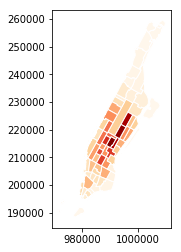

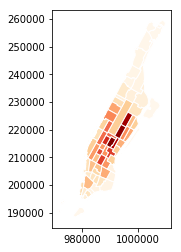

In [109]:
valid_pred_5min_group = valid_pred_5min.groupby(['LocationID']).sum()[['value', 'pred']]
taxi_zones_shape_requests_pred_5min = taxi_zones_shape.join(valid_pred_5min_group, on=['LocationID'], how='left')
taxi_zones_shape_requests_pred_5min.fillna(0, inplace=True)
taxi_zones_shape_requests_pred_5min.plot(column='value', cmap='OrRd', edgecolor='white')
taxi_zones_shape_requests_pred_5min.plot(column='pred', cmap='OrRd', edgecolor='white')

In [110]:
valid_pred_5min_group

,value,pred
LocationID,,
4,1364.000,1410.240
12,220.000,338.090
13,9122.000,8518.650
24,2423.000,2233.148
41,2557.000,2530.533
42,1149.000,1204.610
43,12090.000,11848.455
45,1621.000,1488.859
48,24855.000,24908.846


In [111]:
train_X_5min.to_csv('train_X_5min.csv', index=True)
valid_X_5min.to_csv('valid_X_5min.csv', index=True)